In [14]:
"""
Get the packages we need to manipulate the dataset 
"""
import numpy as np 
import pandas as pd 
import os 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from tqdm import tqdm
from datatools import make_clean_data

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
"""
Specify the directories for data. These are universal for our repository-
this is the only thing you should not change.
"""

#rewrite this in the preferred way using os.join and os.path 

DATA_DIR = './' + 'raw_data'

DATA_NAME = '/CreditCard_data.csv'

"""
The sample Dataset summarizes the usage behavior of about
9000 active credit card holders during the last 6 months
"""

DATA_PATH = DATA_DIR + DATA_NAME

os.listdir(DATA_DIR)

if os.path.isfile(DATA_PATH): 
    print('DATA_PATH is a valid path')
else:
    raise ValueError('DATA_PATH is not valid path')


DATA_PATH is a valid path


In [16]:
"""
Define size of data sample to read-in. Use to_skip to define the logic. 

Import data as pandas dataframe for that format 
"""

SAMPLE_SIZE = 10000

def to_skip(index): 
    """
    Function to be used with pandas skiprows
    """
    keeprow = False
    
    if index <= SAMPLE_SIZE:
        keeprow = True
    else:
        keeprow = False
    
    return keeprow

data_raw = pd.read_csv(DATA_PATH,nrows = SAMPLE_SIZE)
                                              
print('Shape of the data is :', data_raw.shape, '\n')
print('The features of the data:\n', data_raw.columns)

Shape of the data is : (8950, 18) 

The features of the data:
 Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')


In [6]:
"""
Examine a sample of the data
"""
data_raw.head(10)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


In [7]:
"""
Define the features desired to keep, two group of features (in different scale) available:
1. Absolute amount in dollar
2. Rating of frequency \in R([0,1])
""" 

features = data_raw.columns

#Here are the features related to the absolute amount of money
#Some of them can be used as LABEL
ft_basic =['BALANCE', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']
# the last one is the percent of full payment being paid
# ft_basic_keep = ft_basic[:]

#Here are the features related to the frequency
ft_freq= ['BALANCE_FREQUENCY','PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']

#Here are the features haven't been used
ft_unused = set(list(features))-set(ft_basic)-set(ft_freq)

print('Here are the features related to $$:\n', ft_basic,'\n')
print('Here are the features related to frequency: \n',ft_freq,'\n')
print('Here are the features not used: \n', ft_unused)

Here are the features related to $$:
 ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'] 

Here are the features related to frequency: 
 ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY'] 

Here are the features not used: 
 {'TENURE', 'CUST_ID', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX'}


In [5]:
"""
Subset the Raw Data: Here, we refine data according to the desired features to keep defined in the previous cell. Then
we type convert the columns in order to actually apply clustering to them. 
"""

data = data_raw[ft_basic]
ft_kept = data.columns
data.head(10)


,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,40.900749,95.40,0.00,95.40,0.000000,1000.0,201.802084,139.509787,0.000000
1,3202.467416,0.00,0.00,0.00,6442.945483,7000.0,4103.032597,1072.340217,0.222222
2,2495.148862,773.17,773.17,0.00,0.000000,7500.0,622.066742,627.284787,0.000000
3,1666.670542,1499.00,1499.00,0.00,205.788017,7500.0,0.000000,NaN,0.000000
4,817.714335,16.00,16.00,0.00,0.000000,1200.0,678.334763,244.791237,0.000000
5,1809.828751,1333.28,0.00,1333.28,0.000000,1800.0,1400.057770,2407.246035,0.000000
6,627.260806,7091.01,6402.63,688.38,0.000000,13500.0,6354.314328,198.065894,1.000000
7,1823.652743,436.20,0.00,436.20,0.000000,2300.0,679.065082,532.033990,0.000000
8,1014.926473,861.49,661.49,200.00,0.000000,7000.0,688.278568,311.963409,0.000000
9,152.225975,1281.60,1281.60,0.00,0.000000,11000.0,1164.770591,100.302262,0.000000


In [8]:
"""
Clean the Data: Here we identify rows with missing fields in the desired categories. First, nan/None type is filtered and 
the row number is added to a list of rows which will be skipped when reading in the data for processing
"""

#Iterate over the list of desired features to keep. 

rows_nan = list()

#This is an iterative approach by collecting drop-indices from 
#each feature column- this can likely be done across the whole array simultaneously 

for feature in ft_kept:
    feature_series = data[feature]
    missing_bool = feature_series.isnull()
    nan_indices = feature_series.index[missing_bool]
    if not nan_indices.empty:
        print("Issue Feature:\n", feature,'\n', nan_indices, '\n Num of null=', len(nan_indices), '\n\n')
        rows_nan += list(nan_indices)
        print('Here are Nan Indices:', nan_indices)

#Eliminate duplicates and sort 
rows_nan = list(set(rows_nan))
rows_nan.sort()

# Get rid of rows containing null or empty
data_clean = data.drop(rows_nan)

#Check the number of resulting data points 
print('Here is shape of original data:',data.shape,'\n\n')
print('Here is shape of the clean data:', data_clean.shape,'\n Number of Removed Instances =',len(rows_nan))

NameError: name 'ft_kept' is not defined

In [72]:

CLEAN_DATA_DIR = './clean_data'

CLEAN_DATA_FILE = '/clean_credit_data.csv'

CLEAN_DATA_PATH = CLEAN_DATA_DIR + CLEAN_DATA_FILE

data_clean.to_csv(CLEAN_DATA_PATH) 


In [8]:
"""
Here we create a clusterable dataset by converting into Numpy array.
We also additionally extract one feature to be used as label
Return: X: (NxD) data ready to be clustered
        y: (Nx1) categorical label to examine clusters
"""

"""
?????????????????? Will Question: why are we removing any features? We can leave them in for the clustering. 
"""

# specify one label from clean data feature
ft_label = 'CREDIT_LIMIT'
assert ft_label in ft_kept, "Label feature not in features being used"

# the remaining are the real data feature
ft_data = list(ft_kept).copy()
ft_data.remove(ft_label)
X = data_clean[ft_data].values.astype(np.float64)
# label
y = data_clean[ft_label].values
"""
Further grouping needs to be done to convert into categorical label
"""

assert not np.any(np.isnan(X)), "Data contains NaN"
assert np.all(np.isfinite(X)), "Data contains +/-Inf"


In [55]:
# hyperparameter
N = X.shape[0] #number of data
d = X.shape[1] #dimension


In [64]:
"""
Pipeline for Kmeans clustering given input data X
"""
k = 10 # number of clusters
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
center = kmeans.cluster_centers_
kmeans_label = kmeans.labels_

feature correspondence is 
 [(0, 'BALANCE'), (1, 'PURCHASES'), (2, 'ONEOFF_PURCHASES'), (3, 'INSTALLMENTS_PURCHASES'), (4, 'CASH_ADVANCE'), (5, 'PAYMENTS'), (6, 'MINIMUM_PAYMENTS'), (7, 'PRC_FULL_PAYMENT')]


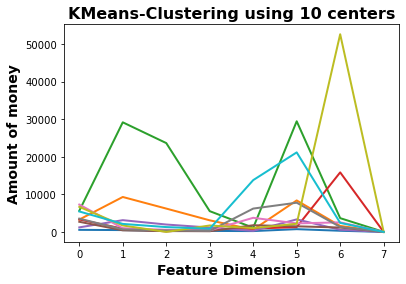

In [48]:
"""
Plotting clusters for KMeans
"""
%matplotlib inline
plt.figure(0)
plt.plot(np.tile(np.arange(d),(k,1)).T,center.T, linewidth = 2)
plt.xlabel('Feature Dimension', fontsize=14, fontweight='bold')
plt.ylabel('Amount of money',fontsize=14, fontweight='bold')
plt.title('KMeans-Clustering using {} centers'.format(k),fontsize=16, fontweight='bold')

print('feature correspondence is \n', [(i, feature) for (i, feature) in enumerate(ft_data)])

In [57]:
"""
Pipeline for GMM clustering given input data X
"""
gm = GaussianMixture(n_components=k, random_state=0).fit(X)
gm_center = gm.means_
gm_label = gm.labels_

feature correspondence is 
 [(0, 'BALANCE'), (1, 'PURCHASES'), (2, 'ONEOFF_PURCHASES'), (3, 'INSTALLMENTS_PURCHASES'), (4, 'CASH_ADVANCE'), (5, 'PAYMENTS'), (6, 'MINIMUM_PAYMENTS'), (7, 'PRC_FULL_PAYMENT')]


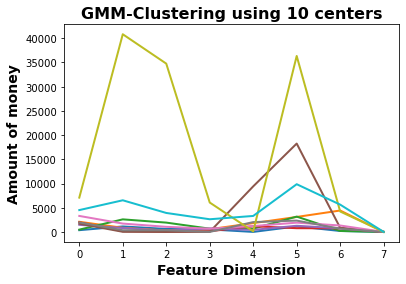

In [17]:
"""
Plotting clusters for GMM
"""
plt.figure(0)
plt.plot(np.tile(np.arange(d),(k,1)).T,gm_center.T, linewidth = 2)
plt.xlabel('Feature Dimension', fontsize=14, fontweight='bold')
plt.ylabel('Amount of money',fontsize=14, fontweight='bold')
plt.title('GMM-Clustering using {} centers'.format(k),fontsize=16, fontweight='bold')
print('feature correspondence is \n', [(i, feature) for (i, feature) in enumerate(ft_data)])


number in each bin is
 [4402 2006 1300  569  210  107   32    6    1    3]


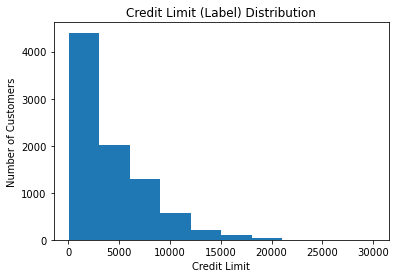

In [29]:
plt.hist(y, bins=10)
plt.title('Credit Limit (Label) Distribution')
plt.xlabel('Credit Limit')
plt.ylabel('Number of Customers')
print('number in each bin is\n', np.histogram(y,bins=10)[0])

Text(0, 0.5, 'Credit Limit')

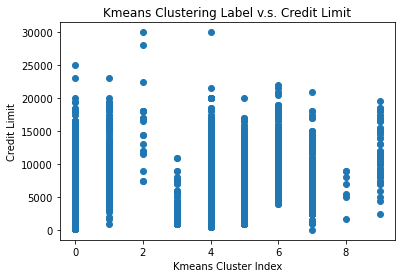

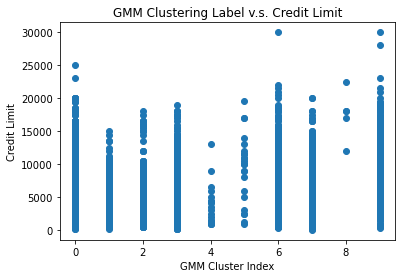

In [58]:
"""
The ideal case should be the Credit Limit is well-separated
according to the clustering indices.
This is in essence a visualization of the homogeneity&completeness metric
"""

plt.figure(1)
plt.scatter(kmeans_label, y)
plt.title('Kmeans Clustering Label v.s. Credit Limit')
plt.xlabel('Kmeans Cluster Index')
plt.ylabel('Credit Limit')

plt.figure(2)
plt.scatter(gm_label, y)
plt.title('GMM Clustering Label v.s. Credit Limit')
plt.xlabel('GMM Cluster Index')
plt.ylabel('Credit Limit')

In [66]:
"""
Here we implement the elbow method with different metric to find
the best number of clusters
"""

k_search = np.linspace(start=5, stop=100, num=20)
silh_score_kmeans = np.zeros(len(k_search))
CHindex_score_kmeans = silh_score_kmeans.copy()
DBindex_score_kmeans = silh_score_kmeans.copy()
SoS = silh_score_kmeans.copy()
for (i,k) in tqdm(enumerate(k_search), total=len(k_search)):
    kmeans = KMeans(n_clusters=int(k), random_state=0).fit(X)
    kmeans_label = kmeans.labels_
    SoS[i] = kmeans.inertia_
    silh_score_kmeans[i] = metrics.silhouette_score(X, kmeans_label, metric='euclidean')
    CHindex_score_kmeans[i] = metrics.calinski_harabasz_score(X,kmeans_label)
    DBindex_score_kmeans[i] = metrics.davies_bouldin_score(X,kmeans_label)


Text(0, 0.5, 'Davies-Bouldin Index¶')

<Figure size 432x288 with 0 Axes>

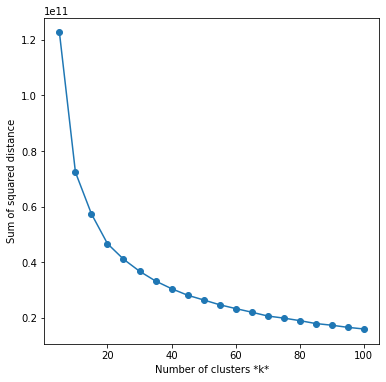

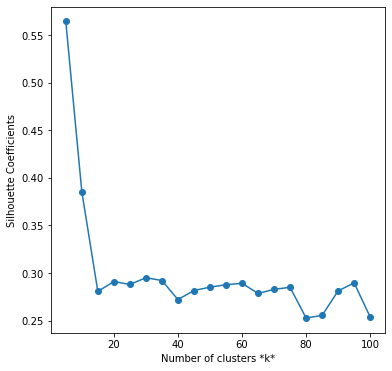

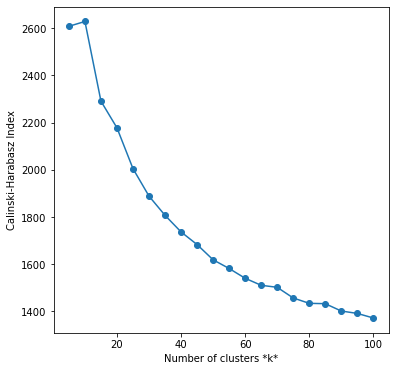

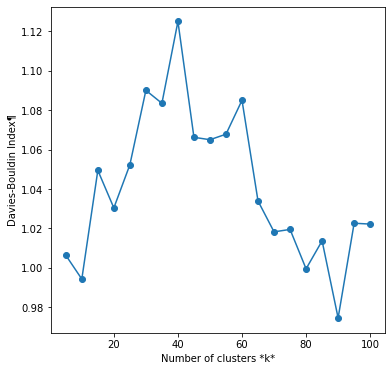

In [68]:
"""
Visualization of Elbow Methods for KMeans
"""
# SoS
plt.figure(0)
plt.figure(figsize=(6, 6))
plt.plot(k_search, SoS, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Sum of squared distance')

# Silhouette
plt.figure(1)
plt.figure(figsize=(6, 6))
plt.plot(k_search, silh_score_kmeans, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Silhouette Coefficients')

# CH index
plt.figure(2)
plt.figure(figsize=(6, 6))
plt.plot(k_search, CHindex_score_kmeans, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Calinski-Harabasz Index')

# DB index
plt.figure(3)
plt.figure(figsize=(6, 6))
plt.plot(k_search, DBindex_score_kmeans, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Davies-Bouldin Index')

In [73]:
"""
Here we implement the elbow method with different metric to find
the best number of clusters
"""

k_search = np.linspace(start=5, stop=100, num=20)
silh_score_gm = np.zeros(len(k_search))
CHindex_score_gm = silh_score_gm.copy()
DBindex_score_gm = silh_score_gm.copy()
# with tqdm(total=total) as pbar:
#     for item in train_iter:
for (i,k) in tqdm(enumerate(k_search), total=len(k_search)):
    gm = GaussianMixture(n_components=int(k), random_state=0).fit(X)
    gm_label = gm.predict(X)

    silh_score_gm[i] = metrics.silhouette_score(X, gm_label, metric='euclidean')
    CHindex_score_gm[i] = metrics.calinski_harabasz_score(X,gm_label)
    DBindex_score_gm[i] = metrics.davies_bouldin_score(X,gm_label)

20it [01:24,  4.22s/it]


Text(0, 0.5, 'Davies-Bouldin Index¶')

<Figure size 432x288 with 0 Axes>

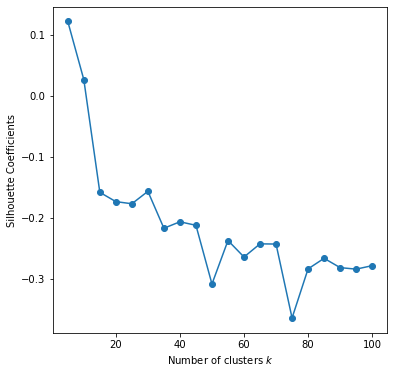

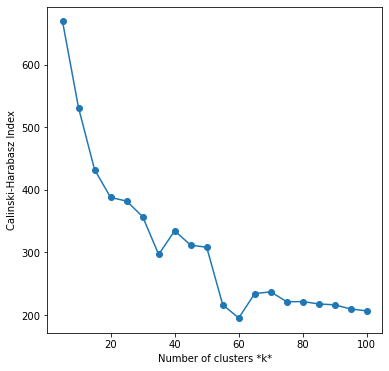

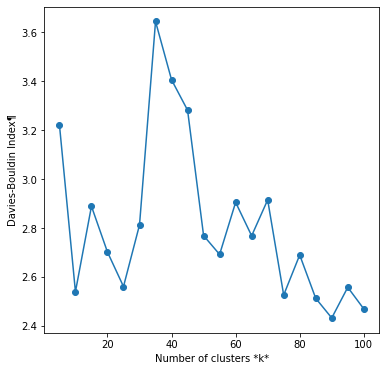

In [75]:
"""
Visualization of Elbow Methods for GMM
"""
# Silhouette
plt.figure(1)
plt.figure(figsize=(6, 6))
plt.plot(k_search, silh_score_gm, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Silhouette Coefficients')

# CH index
plt.figure(2)
plt.figure(figsize=(6, 6))
plt.plot(k_search, CHindex_score_gm, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Calinski-Harabasz Index')

# DB index
plt.figure(3)
plt.figure(figsize=(6, 6))
plt.plot(k_search, DBindex_score_gm, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Davies-Bouldin Index')

In [9]:
#Clear all cache
%reset -f
#Autoload module update
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
"""
Examine the datatools script
"""
from datatools import make_clean_data, select_features, remove_quantiles,\
    get_elbow_index, elbow_method


data_clean, missing_dict, bad_row_index = make_clean_data(data_raw, verbose=True)
data_kept, ft_kept, ft_unused = select_features(data_clean, which='basic')

Issue Feature:
 CREDIT_LIMIT 
 
 Num of null= 1 


Issue Feature:
 MINIMUM_PAYMENTS 
 
 Num of null= 313 


Total Number of Removed Row Instances =  314 
 
Percentage of Removed Features: 
 {'CREDIT_LIMIT': 0.000111731843575419, 'MINIMUM_PAYMENTS': 0.034972067039106144}
Here are the selected features (related to dollars):
 ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'] 

Features retained are: basic

Here are the features not used: 
 ['PURCHASES_FREQUENCY', 'CASH_ADVANCE_TRX', 'BALANCE_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'PURCHASES_TRX', 'CUST_ID', 'TENURE', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']


Percent of Data Removed Across These Quantiles Is:  8.603520148216766


In [178]:
p = np.linspace(0,10,11)*0.1
data_reduced_qunatile = data_kept.copy()
percent_of_zero = np.zeros(len(ft_kept))
eps = 1e-5
for (j,ft) in enumerate(ft_kept):
    ft_new = ft + '_QUANTILE'
    data_reduced_qunatile[ft_new] = 0
    for (i, quantile) in enumerate(p[:-1]):
        quantile_filter = np.quantile(data_kept[ft], [quantile, p[i+1]])
        data_reduced_qunatile.loc[((data_kept[ft]>quantile_filter[0])&
                                   (data_kept[ft]<=quantile_filter[1])), ft_new]=i+1
        if i == 0 and quantile_filter[0]>0: # deal with 0-quantile being non-zero
            data_reduced_qunatile.loc[((data_kept[ft]>=quantile_filter[0])&
                                   (data_kept[ft]<=quantile_filter[1])), ft_new]=i+1

        print(quantile_filter, ft)
        if quantile_filter[0]<= eps and quantile_filter[1] >= eps:
            percent_of_zero[j] = quantile

    data_reduced_qunatile = data_reduced_qunatile.drop(ft, 1)




[ 0.       29.093764] BALANCE
[29.093764 89.579737] BALANCE
[ 89.579737 233.394616] BALANCE
[233.394616 512.011287] BALANCE
[512.011287 916.855459] BALANCE
[ 916.855459 1247.423771] BALANCE
[1247.423771 1736.263934] BALANCE
[1736.263934 2613.123168] BALANCE
[2613.123168  4382.8418065] BALANCE
[ 4382.8418065 19043.13856  ] BALANCE
[0. 0.] PURCHASES
[0. 0.] PURCHASES
[ 0.    94.425] PURCHASES
[ 94.425 223.34 ] PURCHASES
[223.34  375.405] PURCHASES
[375.405 577.98 ] PURCHASES
[577.98  915.925] PURCHASES
[ 915.925 1451.5  ] PURCHASES
[1451.5  2591.36] PURCHASES
[ 2591.36 49039.57] PURCHASES
[0. 0.] ONEOFF_PURCHASES
[0. 0.] ONEOFF_PURCHASES
[0. 0.] ONEOFF_PURCHASES
[0. 0.] ONEOFF_PURCHASES
[ 0.    44.995] ONEOFF_PURCHASES
[ 44.995 177.   ] ONEOFF_PURCHASES
[177.  420.1] ONEOFF_PURCHASES
[420.1 834.8] ONEOFF_PURCHASES
[ 834.8   1627.535] ONEOFF_PURCHASES
[ 1627.535 40761.25 ] ONEOFF_PURCHASES
[0. 0.] INSTALLMENTS_PURCHASES
[0. 0.] INSTALLMENTS_PURCHASES
[0. 0.] INSTALLMENTS_PURCHASES
[0. 0.]

/var/folders/c_/y_0x4rsd6tb4chd_y83jnpzr0000gn/T/ipykernel_54802/1155998711.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_reduced_qunatile = data_reduced_qunatile.drop(ft, 1)
/var/folders/c_/y_0x4rsd6tb4chd_y83jnpzr0000gn/T/ipykernel_54802/1155998711.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_reduced_qunatile = data_reduced_qunatile.drop(ft, 1)
/var/folders/c_/y_0x4rsd6tb4chd_y83jnpzr0000gn/T/ipykernel_54802/1155998711.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_reduced_qunatile = data_reduced_qunatile.drop(ft, 1)
/var/folders/c_/y_0x4rsd6tb4chd_y83jnpzr0000gn/T/ipykernel_54802/1155998711.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the 

[0. 0.] CASH_ADVANCE
[0. 0.] CASH_ADVANCE
[  0.       254.450638] CASH_ADVANCE
[254.450638 825.344843] CASH_ADVANCE
[ 825.344843 1600.758078] CASH_ADVANCE
[1600.758078 3126.9753  ] CASH_ADVANCE
[ 3126.9753  47137.21176] CASH_ADVANCE
[  50. 1200.] CREDIT_LIMIT
[1200. 1500.] CREDIT_LIMIT
[1500. 2000.] CREDIT_LIMIT
[2000. 2500.] CREDIT_LIMIT
[2500. 3000.] CREDIT_LIMIT
[3000. 4500.] CREDIT_LIMIT
[4500. 6000.] CREDIT_LIMIT
[6000. 7000.] CREDIT_LIMIT
[7000. 9500.] CREDIT_LIMIT
[ 9500. 30000.] CREDIT_LIMIT
[4.9513000e-02 2.1477765e+02] PAYMENTS
[214.77765  346.833439] PAYMENTS
[346.833439 497.195284] PAYMENTS
[497.195284 665.239171] PAYMENTS
[665.239171 896.675701] PAYMENTS
[ 896.675701 1233.301038] PAYMENTS
[1233.301038  1653.7194825] PAYMENTS
[1653.7194825 2373.896899 ] PAYMENTS
[2373.896899 4002.988707] PAYMENTS
[ 4002.988707 50721.48336 ] PAYMENTS
[1.91630000e-02 1.06113465e+02] MINIMUM_PAYMENTS
[106.113465 154.583752] MINIMUM_PAYMENTS
[154.583752  178.8627335] MINIMUM_PAYMENTS
[178.86273

/var/folders/c_/y_0x4rsd6tb4chd_y83jnpzr0000gn/T/ipykernel_54802/1155998711.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_reduced_qunatile = data_reduced_qunatile.drop(ft, 1)
/var/folders/c_/y_0x4rsd6tb4chd_y83jnpzr0000gn/T/ipykernel_54802/1155998711.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_reduced_qunatile = data_reduced_qunatile.drop(ft, 1)


In [172]:
percent_of_zero = np.zeros(len(ft_kept))

In [166]:
test = 0
ft = 'ONEOFF_PURCHASES'
ft_new = ft + '_QUANTILE'
data_reduced_qunatile[ft_new] = 0
for [i, quantile] in enumerate(p[:-1]):
    quantile_filter = np.quantile(data_kept[ft], [quantile, p[i+1]])
    data_reduced_qunatile.loc[((data_kept[ft]>=quantile_filter[0])&
                               (data_kept[ft]<quantile_filter[1])), ft_new]=i+1


0
0
1
0
2
0
3
0
4
0
5
205
6
1070
7
1932
8
2796
9
3659


In [171]:
quantile_filter = np.quantile(data_kept[ft], [0.2, 0.3])

In [127]:
p[:-1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [19]:
X_clean = data_kept.values.astype(np.float64)

Running Elbow Method...


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

The elbow (num of clusters) of SoS given by Method 1 is 6.0, by Method 2 is 6.0



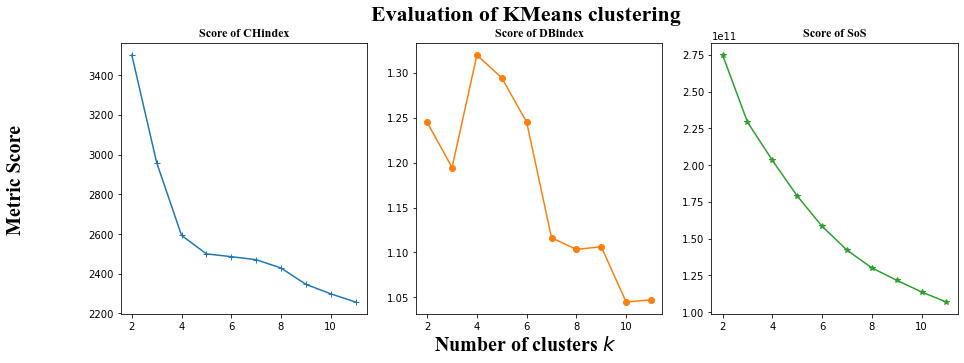

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [112]:
from datatools import data_quantization
a, b = data_quantization(data_kept)


k_search = np.linspace(start=2, stop=11, num=10)

metric_list= elbow_method(X_clean, k_search, 'KMeans')
# print(k_opt)

#low DB, high CH

In [23]:
k_diff = k_search[1:len(k_search)]-k_search[0:len(k_search)-1]
assert min(k_diff) == max(k_diff)

In [59]:
scores = metric_list[-1]
diff1 = np.zeros(len(scores))
diff2 = diff1.copy()
# strength = diff1.copy()
diff1[1:] = (1/k_diff[0])*(scores[1:len(scores)]-scores[0:len(scores)-1])
diff2[2:] = (1/k_diff[0])*(diff1[2:len(diff1)]-diff1[1:len(diff1)-1])
strength[1:-1] = diff2[2:] - diff1[2:]
# res = next(x for (x, val) in enumerate(diff1) if val < 0)


In [43]:
(1/k_diff[0])*(diff1[1:len(diff1)]-diff1[0:len(diff1)-1])

array([-1.45945675e-02,  9.15718553e-03,  2.37906991e-03,  9.49343209e-04,
        8.04327562e-04,  2.50365378e-04,  2.72314104e-04,  8.27466399e-05,
       -3.16276401e-05,  2.52292203e-04, -5.09280121e-05,  6.91306402e-05,
        1.18136893e-04,  1.48650812e-05, -1.03980645e-06,  6.11945367e-05,
       -6.43555879e-05,  1.50193719e-04, -5.39561323e-05])

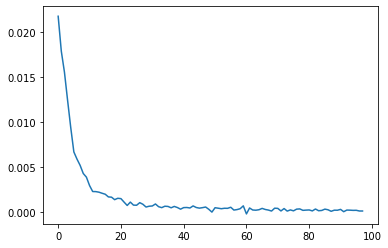

In [60]:
plt.plot(strength[1:])

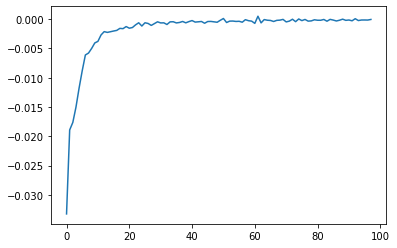

In [57]:
plt.plot(diff1[1:])

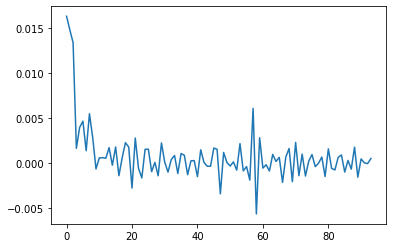

In [68]:
plt.plot(diff2[2:])

In [63]:
import numpy.matlib
curve = scores
nPoints = len(curve)
allCoord = np.vstack((range(nPoints), curve)).T
np.array([range(nPoints), curve])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)

AttributeError: module 'numpy' has no attribute 'repmat'

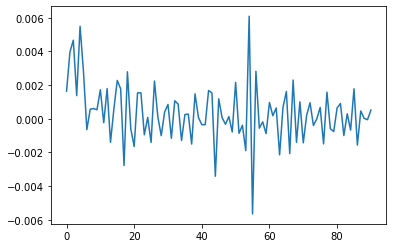

In [67]:
diff2 = scores[2:]+scores[:-2]-2*scores[1:-1]
plt.plot(diff2[6:])

In [97]:
from kneed import KneeLocator
kn = KneeLocator(
    np.array(range(99)),
    scores,
    curve='convex',
    direction='decreasing',
    interp_method='polynomial',
)

In [77]:
np.argmin(abs(metric_list[2][2:] - metric_list[1][2:]))

3

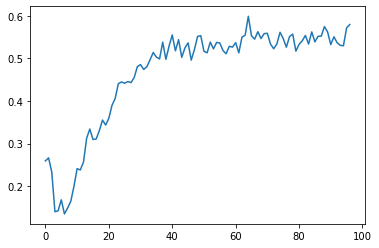

In [79]:

plt.plot(metric_list[2][2:] - metric_list[1][2:])

In [98]:
kn.elbow


15

In [101]:
a = input('Give me an Enter')


[autoreload of datatools failed: Traceback (most recent call last):
  File "/Users/lewisliu/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/lewisliu/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/lewisliu/opt/anaconda3/envs/DataScience/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/lewisliu/opt/anaconda3/envs/DataScience/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_

In [106]:
np.arange(5-2,5+3)

array([3, 4, 5, 6, 7])

[autoreload of datatools failed: Traceback (most recent call last):
  File "/Users/lewisliu/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/lewisliu/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/lewisliu/opt/anaconda3/envs/DataScience/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/lewisliu/opt/anaconda3/envs/DataScience/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_

<Figure size 1080x360 with 0 Axes>